In [1]:
import matplotlib.pyplot as plt
import time
import numpy as np
import pandas as pd
import seaborn as sns
from numpy import ravel
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn import datasets, model_selection, tree, preprocessing, metrics, linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.ensemble import VotingClassifier
from scipy.stats import randint as sp_randint
import datetime
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools

%matplotlib inline

In [2]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
#read data
data = pd.read_csv('../data/bank_full_processed_le.csv')  
# visualize the data
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,pdays_missing,pdays_less_5,pdays_greater_15,pdays_bet_5_15
0,0.481481,3,1,0,2,2,2,1,6,1,0.0,0.0,1,0.9375,0.698753,0.60251,0.957379,0.859735,0,1.0,0.0,0.0,0.0
1,0.493827,7,1,3,1,2,2,1,6,1,0.0,0.0,1,0.9375,0.698753,0.60251,0.957379,0.859735,0,1.0,0.0,0.0,0.0
2,0.246914,7,1,3,2,0,2,1,6,1,0.0,0.0,1,0.9375,0.698753,0.60251,0.957379,0.859735,0,1.0,0.0,0.0,0.0
3,0.283951,0,1,1,2,2,2,1,6,1,0.0,0.0,1,0.9375,0.698753,0.60251,0.957379,0.859735,0,1.0,0.0,0.0,0.0
4,0.481481,7,1,3,2,2,0,1,6,1,0.0,0.0,1,0.9375,0.698753,0.60251,0.957379,0.859735,0,1.0,0.0,0.0,0.0


# Model Building and Evaluation


- **Train Test Split** : Divide the Data set into Train class and Test class for model building and Evaluation


- Used **Stratification split** since the data is imbalanced. A random split might probably have changed the target distribution 

In [5]:
X = data.drop('y', axis=1)
y = data['y']

# SMOTE for oversampling the dataset


- Since the dataset is highly imbalanced containing approximate 88% of NO values in term deposite , training our model on such dataset will create a bias for undersample class(12% of YES values)


- To deal with this situation using SMOTE (Synthetic Minority Oversampling TEchnique) is a good option


- SMOTE first selects a minority class instance a at random and finds its k nearest minority class neighbors. The synthetic instance is then created by choosing one of the k nearest neighbors b at random and connecting a and b to form a line segment in the feature space. The synthetic instances are generated as a convex combination of the two chosen instances a and b.


- The combination of SMOTE and under-sampling performs better than plain under-sampling

In [6]:
print("Dataset shape before SMOTE:-")
print("X:", X.shape)
print("y:",y.shape)


Dataset shape before SMOTE:-
X: (41188, 22)
y: (41188,)


In [7]:
sm = SMOTE(random_state=2)
X, y = sm.fit_resample(X, y.values.ravel())
print("Dataset shape after SMOTE:-")
print("X:", X.shape)
print("y:",y.shape)

Dataset shape after SMOTE:-
X: (73096, 22)
y: (73096,)


# PCA for Feature Reduction

- As  seen our no of features come upto 52 , to reduce this number and making model precise to be used in generalize manner using PCA make sense


- Here our AIM will be to find how mant features are required to capture 90% of variance of our dataset


- Principal component analysis (PCA) is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components. This transformation is defined in such a way that the first principal component has the largest possible variance (that is, accounts for as much of the variability in the data as possible), and each succeeding component in turn has the highest variance possible under the constraint that it is orthogonal to the preceding components.

In [8]:
pca = PCA(n_components=0.9).fit(X)
x_pca1 = pca.transform(X)
X.shape, x_pca1.shape

((73096, 22), (73096, 5))

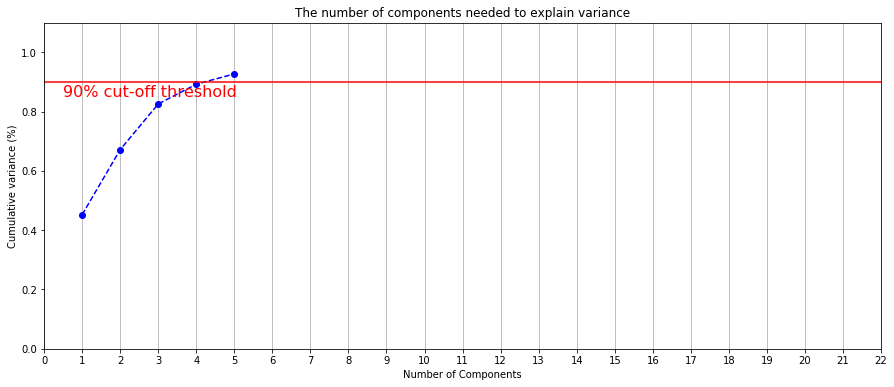

In [9]:
#pca = PCA(n_components=0.9).fit(X)

#% matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,6)

fig, ax = plt.subplots()
xi = np.arange(1, 6, step=1)
y1 = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y1, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 23, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.90, color='r', linestyle='-')
plt.text(0.5, 0.85, '90% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [10]:
# number of components
n_pcs= pca.components_.shape[0]
# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'previous',
       'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed', 'y', 'pdays_missing', 'pdays_less_5',
       'pdays_greater_15', 'pdays_bet_5_15']
# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]


In [11]:
# LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
pca_df = pd.DataFrame(dic.items())
pca_df

,0,1
0,PC0,job
1,PC1,month
2,PC2,education
3,PC3,day_of_week
4,PC4,housing


# Observation
- Only 5 features are needed to cover 90% variance of the dataset , so its better to perform PCA to reduce 23 features to 5

- Split performed without Stratification

In [12]:
X_train, X_test, y_train, y_test = train_test_split(x_pca1, y, test_size=0.2, random_state=1)
print('Original:', (data.y).mean(), 'Train:', (y_train).mean(), 'Test:', (y_test).mean())

Original: 0.11265417111780131 Train: 0.5010089609412408 Test: 0.49596443228454173


- Split performed with Stratification

In [13]:
X_train, X_test, y_train, y_test = train_test_split(x_pca1, y, test_size=0.2, stratify=y, random_state=1)
print('Original:', (data.y).mean(), 'Train:', (y_train).mean(), 'Test:', (y_test).mean())

Original: 0.11265417111780131 Train: 0.5 Test: 0.5


# Performing Different Algorithms to find the best fit for our dataset
- Will try following different algorithms to see which algorithm fits best on our dataset in terms of accuracy, ROC, AUC


- Performing Random Hyperparameter search and GridSearch for Hyperparameters, to select the best hyperparameters for a given algorithm

In [14]:
# Function that runs the requested algorithm and returns the accuracy metrics
def fit_ml_algo(algo, X_train, y_train, X_test, cv):
    # One Pass
    model = algo.fit(X_train, y_train)
    test_pred = model.predict(X_test)
    if (isinstance(algo, (LogisticRegression, 
                          KNeighborsClassifier, 
                          GaussianNB, 
                          DecisionTreeClassifier, 
                          RandomForestClassifier,
                          GradientBoostingClassifier,
                          BaggingClassifier,
                          AdaBoostClassifier,
                          XGBClassifier,
                          
                          
                          ))):
        probs = model.predict_proba(X_test)[:,1]
    else:
        probs = "Not Available"
    acc = round(model.score(X_test, y_test) * 100, 2) 
    # CV 
    train_pred = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    try:
        feature_importances = np.mean([tree.feature_importances_ for tree in algo.estimators_], axis=0)
    except:
        feature_importances = 'none'
    
    return train_pred, test_pred, acc, acc_cv, probs,feature_importances

In [15]:
# calculate the fpr and tpr for all thresholds of the classification
def plot_roc_curve(y_test, preds):
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [16]:
def make_confusion_matrix(y,y_pred,categories='auto',count=True,percent=True,cbar=True,xyticks=True,
                          figsize=(7,7),cmap='Blues',title=None):
    cf = confusion_matrix(y, y_pred)
    blanks = ['' for i in range(cf.size)]
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    categories = ['No', 'Yes']

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        cm_sum = np.sum(cf, axis=1, keepdims=True)
        cm_perc = cf / cm_sum.astype(float) * 100
        annot = np.empty_like(cf).astype(str)
        nrows, ncols = cf.shape
        for i in range(nrows):
            for j in range(ncols):
                c = cf[i, j]
            #p = cm_perc[i, j]
                if i == j:
                    s = cm_sum[i]
                    annot[i, j] = '%d/%d\n' % (c, s)
                elif c == 0:
                    annot[i, j] = ''
                else:
                    annot[i, j] = '%d\n' % (c)
        group_counts = list(annot.flat)
        
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])
     # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if title:
        plt.title(title)

# Logistic Regression

Accuracy before CV: 54.64
Accuracy CV 10-Fold: 54.79
Running Time for the Algorithm to train and pred: 0:00:09.396366


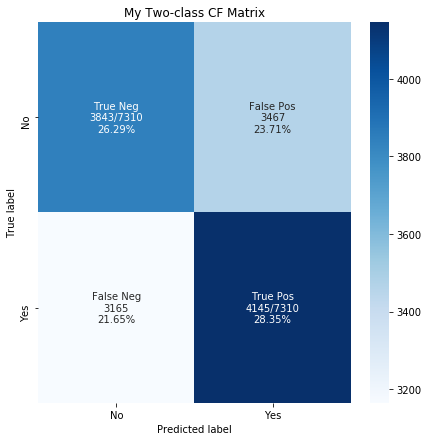

In [17]:
start_time = time.time()
train_pred_log, test_pred_log, acc_log, acc_cv_log, probs_log,feature_log = fit_ml_algo(LogisticRegression(n_jobs = -1), 
                                                                 X_train, 
                                                                 y_train, 
                                                                 X_test, 
                                                                 10)
log_time = (time.time() - start_time)
print('\033[1m' + "Accuracy before CV: %s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)
print("Running Time for the Algorithm to train and pred: %s" % datetime.timedelta(seconds=log_time))
make_confusion_matrix(y_test,test_pred_log, title='My Two-class CF Matrix')


Classification Report on Training :-
              precision    recall  f1-score   support

           0       0.55      0.53      0.54     29238
           1       0.55      0.57      0.56     29238

    accuracy                           0.55     58476
   macro avg       0.55      0.55      0.55     58476
weighted avg       0.55      0.55      0.55     58476

Classification Report on Testing :-
              precision    recall  f1-score   support

           0       0.55      0.53      0.54      7310
           1       0.54      0.57      0.56      7310

    accuracy                           0.55     14620
   macro avg       0.55      0.55      0.55     14620
weighted avg       0.55      0.55      0.55     14620

ROC and AUC curve :-


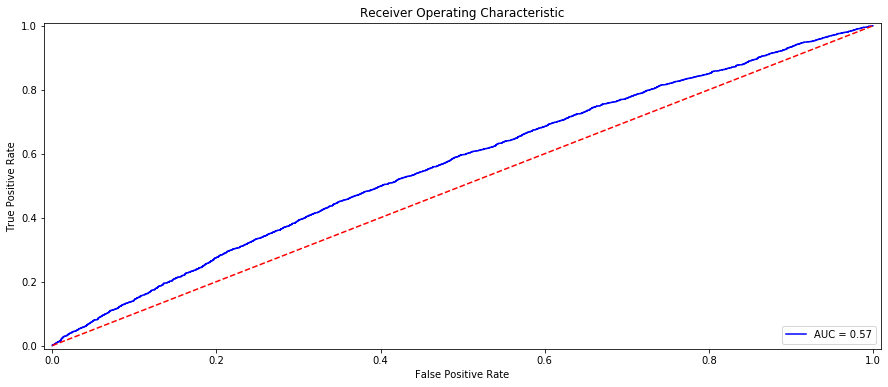

In [18]:
print("Classification Report on Training :-")
print (metrics.classification_report(y_train, train_pred_log))
print("Classification Report on Testing :-")
print (metrics.classification_report(y_test, test_pred_log))
print("ROC and AUC curve :-")
plot_roc_curve(y_test, probs_log)

# K-Nearest Neighbors

In [19]:
alpha = [x for x in range(1, 70, 7)]
cv_auc_array=[]
for i in alpha:
    k_cfl=KNeighborsClassifier(n_neighbors=i)
    k_cfl.fit(X_train,y_train)
    predict_y = k_cfl.predict_proba(X_test)
    cv_auc_array.append(roc_auc_score(y_test, predict_y[:,1]))
for i in range(len(cv_auc_array)):
    print ('AUC for k = ',alpha[i],'is',cv_auc_array[i])
best_alpha = np.argmax(cv_auc_array)

AUC for k =  1 is 0.8554719562243501
AUC for k =  8 is 0.86003998233404
AUC for k =  15 is 0.8337746673129214
AUC for k =  22 is 0.813988689294316
AUC for k =  29 is 0.7972381779358897
AUC for k =  36 is 0.7864464940368029
AUC for k =  43 is 0.7774845563205397
AUC for k =  50 is 0.7710417489300304
AUC for k =  57 is 0.764594815115624
AUC for k =  64 is 0.7591036490312729


Accuracy before CV: 77.69
Accuracy CV 10-Fold: 77.39
Running Time for the Algorithm to train and pred: 0:00:06.244303


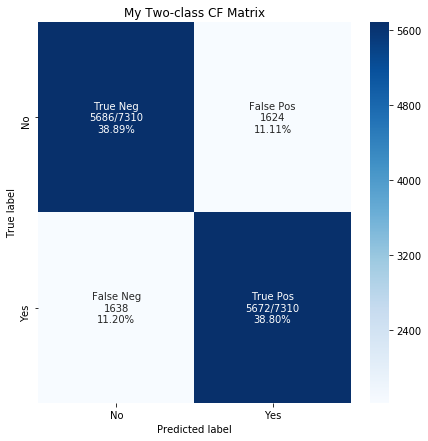

In [20]:

# k-Nearest Neighbors
start_time = time.time()
train_pred_knn, test_pred_knn, acc_knn, acc_cv_knn, probs_knn,feature_knn = fit_ml_algo(KNeighborsClassifier(n_neighbors=alpha[best_alpha],
                                                                                                   n_jobs = -1), 
                                                                                                 X_train, 
                                                                                                 y_train, 
                                                                                                 X_test, 
                                                                                                 10)
knn_time = (time.time() - start_time)
print('\033[1m' + "Accuracy before CV: %s" % acc_knn)
print("Accuracy CV 10-Fold: %s" % acc_cv_knn)
print("Running Time for the Algorithm to train and pred: %s" % datetime.timedelta(seconds=knn_time))
make_confusion_matrix(y_test,test_pred_knn, title='My Two-class CF Matrix')


Classification Report on Training :-
              precision    recall  f1-score   support

           0       0.77      0.78      0.78     29238
           1       0.78      0.77      0.77     29238

    accuracy                           0.77     58476
   macro avg       0.77      0.77      0.77     58476
weighted avg       0.77      0.77      0.77     58476

Classification Report on Testing :-
              precision    recall  f1-score   support

           0       0.78      0.78      0.78      7310
           1       0.78      0.78      0.78      7310

    accuracy                           0.78     14620
   macro avg       0.78      0.78      0.78     14620
weighted avg       0.78      0.78      0.78     14620

ROC and AUC curve :-


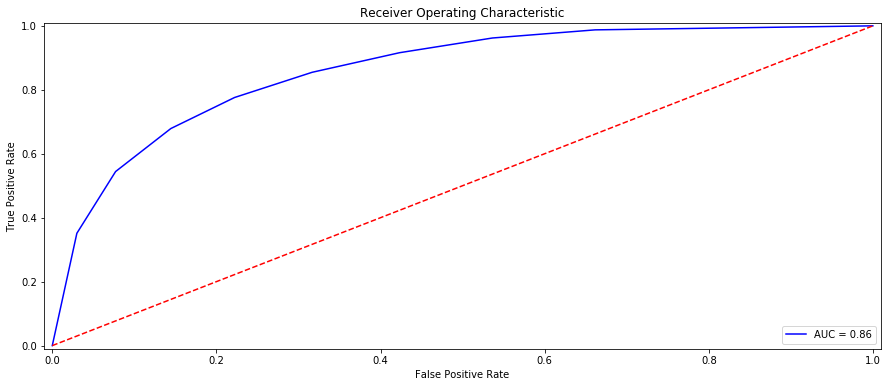

In [21]:
print("Classification Report on Training :-")
print (metrics.classification_report(y_train, train_pred_knn))
print("Classification Report on Testing :-")
print (metrics.classification_report(y_test, test_pred_knn))
print("ROC and AUC curve :-")
plot_roc_curve(y_test, probs_knn)

# Gaussian Naive Bayes

Accuracy: 57.98
Accuracy CV 10-Fold: 57.3
Running Time for the Algorithm to train and pred: 0:00:00.250963


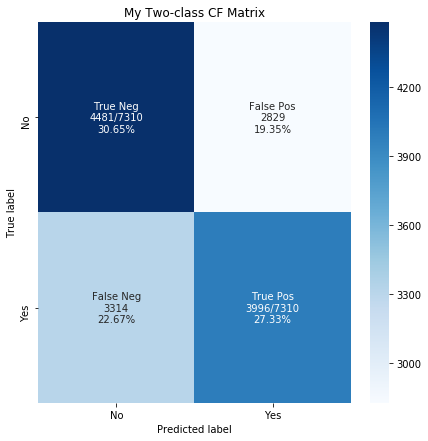

In [22]:
# Gaussian Naive Bayes
start_time = time.time()
train_pred_gaussian, test_pred_gaussian, acc_gaussian, acc_cv_gaussian, probs_gau,feature_gau = fit_ml_algo(GaussianNB(), 
                                                                                     X_train, 
                                                                                     y_train, 
                                                                                     X_test, 
                                                                                     10)
gaussian_time = (time.time() - start_time)
print('\033[1m' +"Accuracy: %s" % acc_gaussian)
print("Accuracy CV 10-Fold: %s" % acc_cv_gaussian)
print("Running Time for the Algorithm to train and pred: %s" % datetime.timedelta(seconds=gaussian_time))
make_confusion_matrix(y_test,test_pred_gaussian, title='My Two-class CF Matrix')


Classification Report on Training :-
              precision    recall  f1-score   support

           0       0.57      0.61      0.59     29238
           1       0.58      0.54      0.56     29238

    accuracy                           0.57     58476
   macro avg       0.57      0.57      0.57     58476
weighted avg       0.57      0.57      0.57     58476

Classification Report on Testing :-
              precision    recall  f1-score   support

           0       0.57      0.61      0.59      7310
           1       0.59      0.55      0.57      7310

    accuracy                           0.58     14620
   macro avg       0.58      0.58      0.58     14620
weighted avg       0.58      0.58      0.58     14620

ROC and AUC curve :-


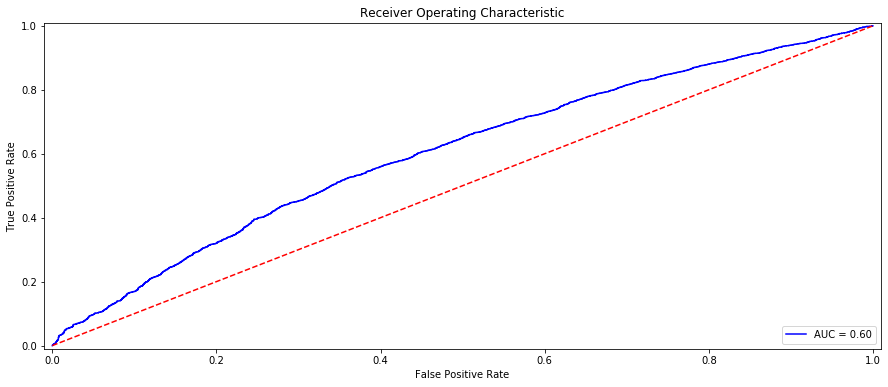

In [23]:
print("Classification Report on Training :-")
print (metrics.classification_report(y_train, train_pred_gaussian))
print("Classification Report on Testing :-")
print (metrics.classification_report(y_test, test_pred_gaussian))
print("ROC and AUC curve :-")
plot_roc_curve(y_test, probs_gau)

# Decision Tree Classifier

Accuracy: 83.96
Accuracy CV 10-Fold: 83.04
Running Time for the Algorithm to train and pred: 0:00:04.620418


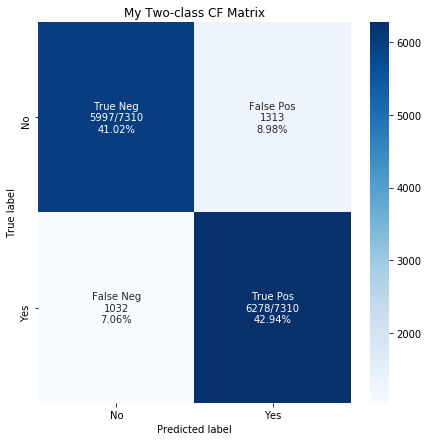

In [24]:
# Decision Tree Classifier
start_time = time.time()
train_pred_dt, test_pred_dt, acc_dt, acc_cv_dt, probs_dt,feature_dt = fit_ml_algo(DecisionTreeClassifier(), 
                                                             X_train, 
                                                             y_train, 
                                                             X_test, 
                                                             10)
dt_time = (time.time() - start_time)
print('\033[1m' + "Accuracy: %s" % acc_dt)
print("Accuracy CV 10-Fold: %s" % acc_cv_dt)
print("Running Time for the Algorithm to train and pred: %s" % datetime.timedelta(seconds=dt_time))
make_confusion_matrix(y_test,test_pred_dt, title='My Two-class CF Matrix')


Classification Report on Training :-
              precision    recall  f1-score   support

           0       0.84      0.81      0.83     29238
           1       0.82      0.85      0.83     29238

    accuracy                           0.83     58476
   macro avg       0.83      0.83      0.83     58476
weighted avg       0.83      0.83      0.83     58476

Classification Report on Testing :-
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      7310
           1       0.83      0.86      0.84      7310

    accuracy                           0.84     14620
   macro avg       0.84      0.84      0.84     14620
weighted avg       0.84      0.84      0.84     14620

ROC and AUC curve :-


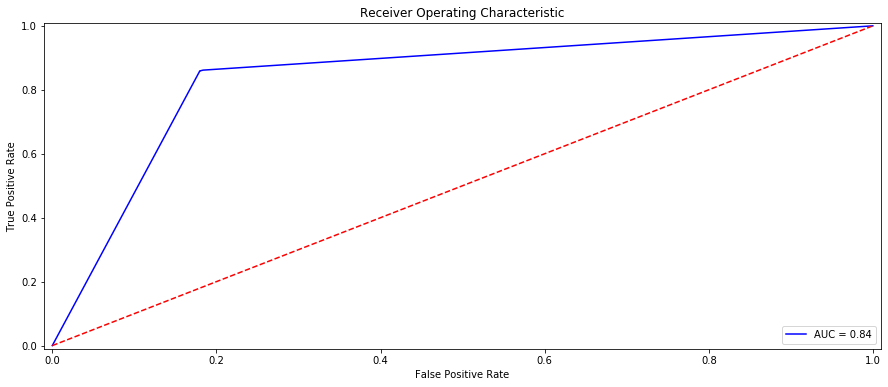

In [25]:
print("Classification Report on Training :-")
print (metrics.classification_report(y_train, train_pred_dt))
print("Classification Report on Testing :-")
print (metrics.classification_report(y_test, test_pred_dt))
print("ROC and AUC curve :-")
plot_roc_curve(y_test, probs_dt)

# Random Forest Classifier

Accuracy: 84.04
Accuracy CV 10-Fold: 82.89
Running Time for the Algorithm to train and pred: 0:00:25.209373


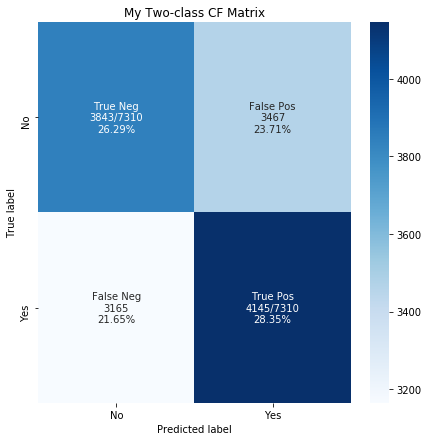

In [26]:

start_time = time.time()
rfc = RandomForestClassifier(n_estimators=10, 
                             min_samples_leaf=2,
                             min_samples_split=17, 
                             criterion='gini', 
                             max_features=5)
train_pred_rf, test_pred_rf, acc_rf, acc_cv_rf, probs_rf,feature_rf = fit_ml_algo(rfc, 
                                                             X_train, 
                                                             y_train, 
                                                             X_test, 
                                                             10)
rf_time = (time.time() - start_time)
print('\033[1m' + "Accuracy: %s" % acc_rf)
print("Accuracy CV 10-Fold: %s" % acc_cv_rf)
print("Running Time for the Algorithm to train and pred: %s" % datetime.timedelta(seconds=rf_time))
make_confusion_matrix(y_test,test_pred_log, title='My Two-class CF Matrix')


Classification Report on Training :-
              precision    recall  f1-score   support

           0       0.84      0.81      0.83     29238
           1       0.82      0.85      0.83     29238

    accuracy                           0.83     58476
   macro avg       0.83      0.83      0.83     58476
weighted avg       0.83      0.83      0.83     58476

Classification Report on Testing :-
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      7310
           1       0.83      0.86      0.84      7310

    accuracy                           0.84     14620
   macro avg       0.84      0.84      0.84     14620
weighted avg       0.84      0.84      0.84     14620

ROC and AUC curve :-


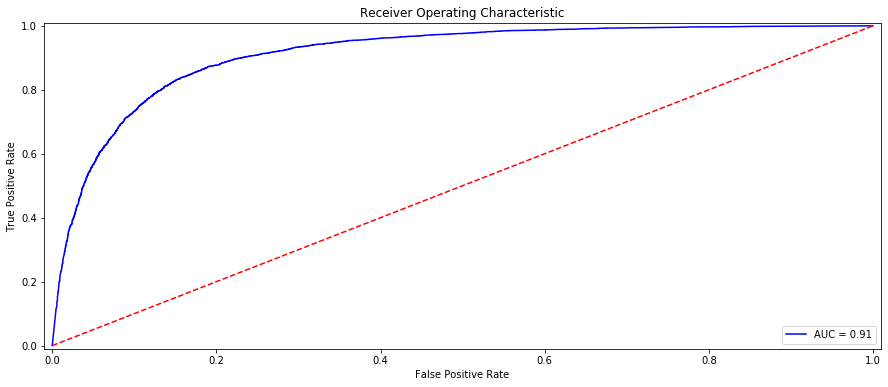

In [27]:
print("Classification Report on Training :-")
print (metrics.classification_report(y_train, train_pred_rf))
print("Classification Report on Testing :-")
print (metrics.classification_report(y_test, test_pred_rf))
print("ROC and AUC curve :-")
plot_roc_curve(y_test, probs_rf)

# Gradient Boosting Trees

Accuracy: 71.59
Accuracy CV 10-Fold: 72.17
Running Time for the Algorithm to train and pred: 0:01:39.011497


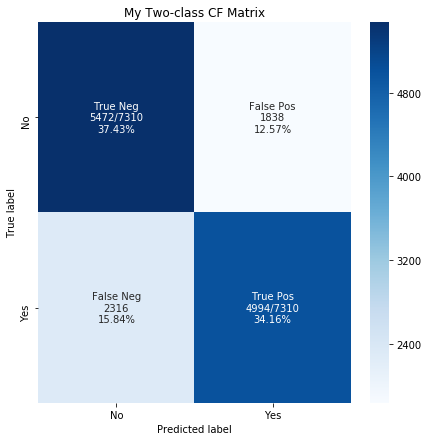

In [28]:
start_time = time.time()
train_pred_gbt, test_pred_gbt, acc_gbt, acc_cv_gbt, probs_gbt,feature_gbt = fit_ml_algo(GradientBoostingClassifier(), 
                                                                 X_train, 
                                                                 y_train, 
                                                                 X_test, 
                                                                 10)
gbt_time = (time.time() - start_time)
print('\033[1m' +"Accuracy: %s" % acc_gbt)
print("Accuracy CV 10-Fold: %s" % acc_cv_gbt)
print("Running Time for the Algorithm to train and pred: %s" % datetime.timedelta(seconds=gbt_time))
make_confusion_matrix(y_test,test_pred_gbt, title='My Two-class CF Matrix')


Classification Report on Training :-
              precision    recall  f1-score   support

           0       0.71      0.76      0.73     29238
           1       0.74      0.69      0.71     29238

    accuracy                           0.72     58476
   macro avg       0.72      0.72      0.72     58476
weighted avg       0.72      0.72      0.72     58476

Classification Report on Testing :-
              precision    recall  f1-score   support

           0       0.70      0.75      0.72      7310
           1       0.73      0.68      0.71      7310

    accuracy                           0.72     14620
   macro avg       0.72      0.72      0.72     14620
weighted avg       0.72      0.72      0.72     14620

ROC and AUC curve :-


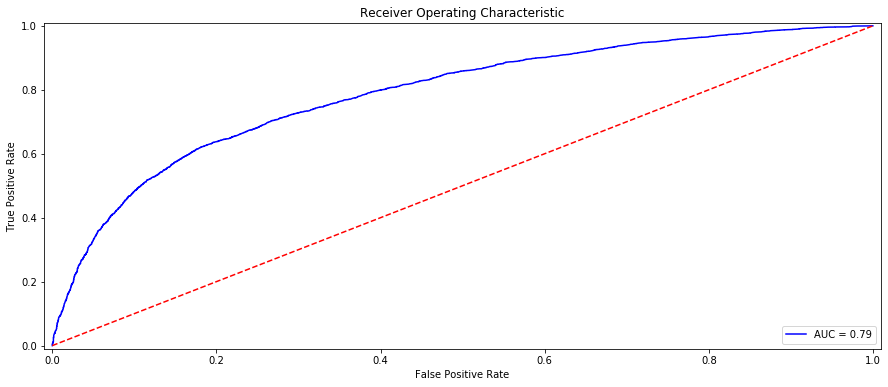

In [29]:
print("Classification Report on Training :-")
print (metrics.classification_report(y_train, train_pred_gbt))
print("Classification Report on Testing :-")
print (metrics.classification_report(y_test, test_pred_gbt))
print("ROC and AUC curve :-")
plot_roc_curve(y_test, probs_gbt)

# BaggingClassifier

Accuracy: 86.38
Accuracy CV 10-Fold: 85.73
Running Time for the Algorithm to train and pred: 0:06:07.791322


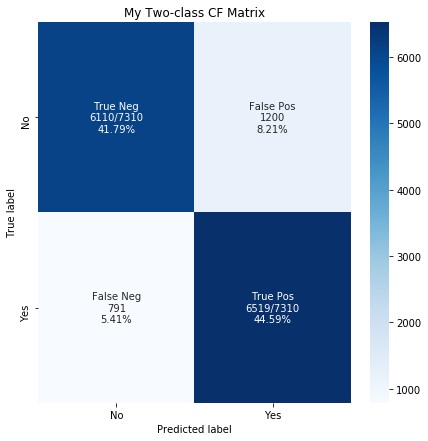

In [30]:
start_time = time.time()
dt_model = DecisionTreeClassifier(criterion = 'entropy',random_state=100)
train_pred_bc, test_pred_bc, acc_bc, acc_cv_bc, probs_bc,feature_bc = fit_ml_algo(BaggingClassifier(base_estimator=dt_model, n_estimators=100,random_state=100), 
                                                                 X_train, 
                                                                 y_train, 
                                                                 X_test, 
                                                                 10)
bc_time = (time.time() - start_time)
print('\033[1m' + "Accuracy: %s" % acc_bc)
print("Accuracy CV 10-Fold: %s" % acc_cv_bc)
print("Running Time for the Algorithm to train and pred: %s" % datetime.timedelta(seconds=bc_time))
make_confusion_matrix(y_test,test_pred_bc, title='My Two-class CF Matrix')


Classification Report on Training :-
              precision    recall  f1-score   support

           0       0.88      0.83      0.85     29238
           1       0.84      0.88      0.86     29238

    accuracy                           0.86     58476
   macro avg       0.86      0.86      0.86     58476
weighted avg       0.86      0.86      0.86     58476

Classification Report on Testing :-
              precision    recall  f1-score   support

           0       0.89      0.84      0.86      7310
           1       0.84      0.89      0.87      7310

    accuracy                           0.86     14620
   macro avg       0.86      0.86      0.86     14620
weighted avg       0.86      0.86      0.86     14620

ROC and AUC curve :-


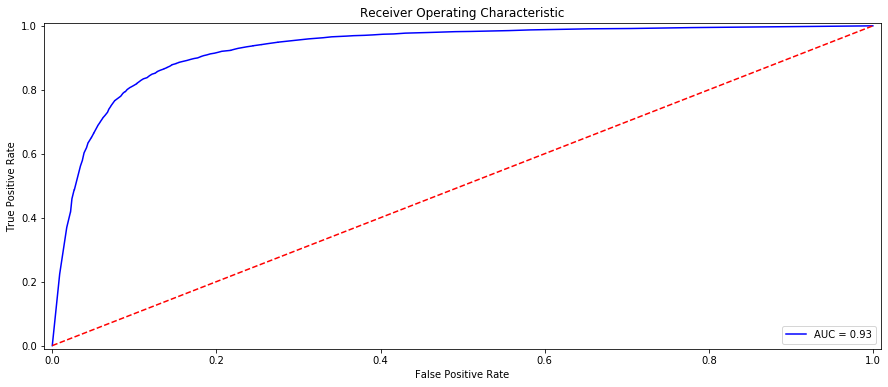

In [31]:
print("Classification Report on Training :-")
print (metrics.classification_report(y_train, train_pred_bc))
print("Classification Report on Testing :-")
print (metrics.classification_report(y_test, test_pred_bc))
print("ROC and AUC curve :-")
plot_roc_curve(y_test, probs_bc)

Text(0, 0.5, 'Feature Names')

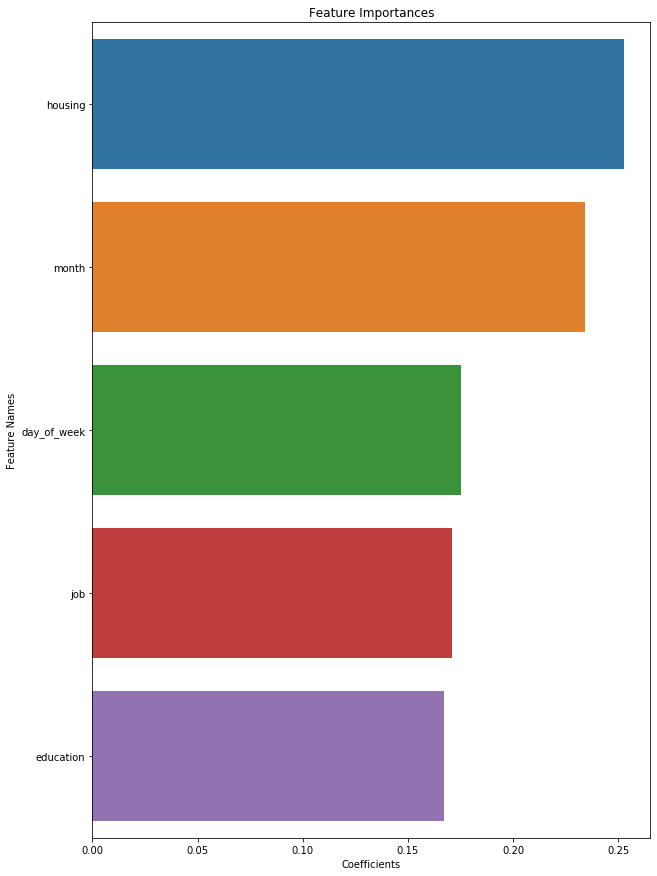

In [32]:
'''Plots feature importance in a sorted order and shows the most significant variables at the top'''
X1 = most_important_names
#X.remove('y_yes')
feature_importance_df = pd.DataFrame(data = feature_bc, index = X1, columns=['coefficient_values'])
feature_importance_df['sort'] = feature_importance_df.coefficient_values.abs()
sorted_feature_imp_df = feature_importance_df.sort_values(by='sort', ascending=False).drop('sort', axis=1)
fig, ax = plt.subplots()
fig.set_size_inches(10, 15)
sns.barplot(np.array(sorted_feature_imp_df.coefficient_values), np.array(sorted_feature_imp_df.index.values))
plt.title('Feature Importances')
plt.xlabel('Coefficients')
plt.ylabel('Feature Names')

# XGBoost

Accuracy: 73.5
Accuracy CV 10-Fold: 73.91
Running Time for the Algorithm to train and pred: 0:00:45.263999


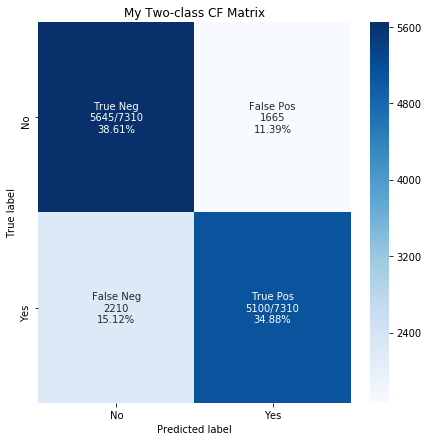

In [33]:
start_time = time.time()

train_pred_xgb1, test_pred_xgb1, acc_xgb1, acc_cv_xgb1, probs_xgb1, feature_xgb1 = fit_ml_algo(xgb.XGBClassifier(max_depth=5, n_estimators=100 ,class_weight='balanced', n_jobs=-1), 
                                                                 X_train, 
                                                                 y_train, 
                                                                 X_test, 
                                                                 10)
xgb_time1 = (time.time() - start_time)
print('\033[1m' + "Accuracy: %s" % acc_xgb1)
print("Accuracy CV 10-Fold: %s" % acc_cv_xgb1)
print("Running Time for the Algorithm to train and pred: %s" % datetime.timedelta(seconds=xgb_time1))
make_confusion_matrix(y_test,test_pred_xgb1, title='My Two-class CF Matrix')


Classification Report on Training :-
              precision    recall  f1-score   support

           0       0.72      0.77      0.75     29238
           1       0.76      0.71      0.73     29238

    accuracy                           0.74     58476
   macro avg       0.74      0.74      0.74     58476
weighted avg       0.74      0.74      0.74     58476

Classification Report on Testing :-
              precision    recall  f1-score   support

           0       0.72      0.77      0.74      7310
           1       0.75      0.70      0.72      7310

    accuracy                           0.73     14620
   macro avg       0.74      0.73      0.73     14620
weighted avg       0.74      0.73      0.73     14620

ROC and AUC curve :-


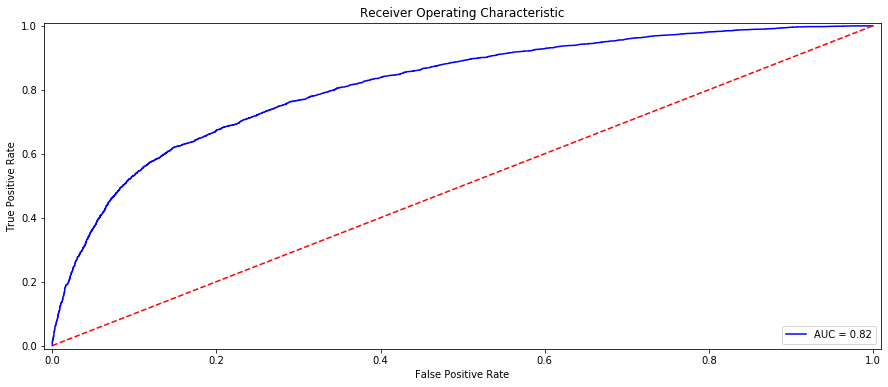

In [34]:
print("Classification Report on Training :-")
print (metrics.classification_report(y_train, train_pred_xgb1))
print("Classification Report on Testing :-")
print (metrics.classification_report(y_test, test_pred_xgb1))
print("ROC and AUC curve :-")
plot_roc_curve(y_test, probs_xgb1)

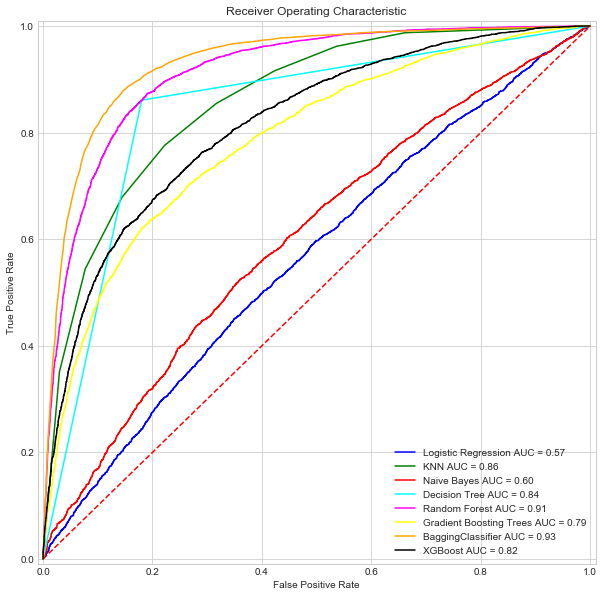

In [35]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(10,10)) 

models = [ 
    'Logistic Regression', 
    'KNN',
    'Naive Bayes',
    'Decision Tree', 
    'Random Forest', 
    'Gradient Boosting Trees',
    'BaggingClassifier',
    'XGBoost'
]
probs = [
    probs_log,
    probs_knn,
    probs_gau,
    probs_dt,
    probs_rf,
    probs_gbt,
    probs_bc,
    probs_xgb1
]
colors = [
    'blue',
    'green',
    'red',
    'cyan',
    'magenta',
    'yellow',
    'orange',
    'black'
]
    
plt.title('Receiver Operating Characteristic')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

def plot_roc_curves(y_test, prob, model):
    fpr, tpr, threshold = metrics.roc_curve(y_test, prob)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, 'b', label = model + ' AUC = %0.2f' % roc_auc, color=colors[i])
    plt.legend(loc = 'lower right')
    
for i, model in list(enumerate(models)):
    plot_roc_curves(y_test, probs[i], models[i])
    
plt.show()
